# Система рекомендации Аниме
Популярные сервисы, такие как Netflix, Amazon и YouTube, предлагают пользователям персональные рекомендации по продуктам, основанные на их предыдущих взаимодействиях. Рекомендательные системы-это то, что обеспечивает волшебство за точными (и часто жуткими) рекомендациями. Рассматривается набор различных стратегий рекомендаций, реализуемых их с нуля. Явные данные рейтинга пользователей, собранные из https://myanimelist.net/ используется для рекомендации аниме, в автономном режиме.

В этой тетради построены различные рекомендательные системы (RecSys), используя явные данные рейтинга аниме, собранных от пользователей с сайта https://myanimelist.net/.

Набор данных [www.kaggle.com](https://www.kaggle.com/CooperUnion/anime-recommendations-database#anime.csv) состоит из предпочтений от 73 516 пользователей на 12 294 различных аниме-сериалов, фильмов, OVA и т.д.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
cm = sns.light_palette("pink" ,as_cmap=True)
import os
import implicit

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 80)
pd.options.display.max_rows=10

results_path = 'modelTestResults.csv'

## Очистка данных, EDA
Данные о рейтингах пользователей хранятся в `rating.csv`
<br>Имеют следующие столбцы:
- `user_id` -  уникальный идентификатор пользователя.
- `anime_id` - аниме, которое оценил этот пользователь.
- `rating` - рейтинг аниме, присвоенный этим пользователем (-1, если пользователь смотрел его, но не присвоил рейтинг).

In [2]:
# rating data
user_ratings = pd.read_csv("data/rating.csv")
print(user_ratings.dtypes)
user_ratings

user_id     int64
anime_id    int64
rating      int64
dtype: object


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [3]:
# Drop duplicate
user_ratings.drop_duplicates(subset=['user_id','anime_id'], inplace=True)
user_ratings.reset_index(inplace=True, drop=True)
print(user_ratings.shape)

(7813730, 3)


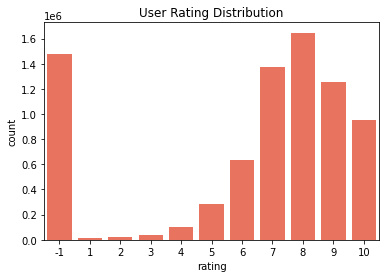

count    7813730.0
mean           6.1
std            3.7
min           -1.0
25%            6.0
50%            7.0
75%            9.0
max           10.0
Name: rating, dtype: float64


In [4]:
# Rating distribution
sns.countplot(user_ratings['rating'],
               color='tomato').set_title('User Rating Distribution')
plt.show()
print(user_ratings.describe()['rating'].round(1))

Распределения рейтингов показывает, что большая часть пользователей, которые отметили аниме как "просмотренное", на самом деле не предоставили рейтинг (указано значение `-1`). Распределение предоставленных оценок имеет левый наклон по шкале 1-10.

Это нормальное поведение для пользователей и приводит к разреженному распределению оценок. Переназначим все значения `-1`на`0`.

In [5]:
user_ratings.loc[user_ratings['rating'] == -1, 'rating'] = 0

###  Данные о аниме
Набор данных аниме состоит из следующей инфы:
- `anime_id` - id аниме.
- `name` - полное название аниме.
- `genre` - разделенный запятыми список жанров аниме.
- `type` - movie, TV, OVA, etc.
- `episodes` - количество эпизодов.
- `rating` - средний рейтинг из 10.
- `members` - количество членов сообщества, которые находятся в "группе" этого аниме.

In [6]:
# anime data
anime = pd.read_csv("data/anime.csv")
print(anime.dtypes)
anime

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [7]:
# количество пропущенных значений
pd.isnull(anime).sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Поскольку в некоторых столбцах отсутствуют значения, они должны быть очищены, для использования их в качестве переменных. Надо создать два отдельных фрейма данных, один из которых будет содержать только информацию о усреднённом рейтинге, а другой-все переменные.

In [8]:
# null ratings
idx_null_rating = pd.Index(anime['rating']).isnull()

anime = anime.loc[~idx_null_rating]  # Drop null rows in 'rating'
anime.drop_duplicates(inplace=True)  # Drop duplicates

# Проверка, согласованы ли anime_id между с фреймом user_ratings, чтобы избежать ошибок индексирования позже
ur_anime_ids  = user_ratings['anime_id'].unique()
all_anime_ids = anime.anime_id.values

for anime_id in ur_anime_ids:
    if anime_id not in all_anime_ids:
        user_ratings = user_ratings.loc[~(user_ratings['anime_id']==anime_id)]

for anime_id in all_anime_ids:
    if anime_id not in ur_anime_ids:
        anime = anime.loc[~(anime['anime_id']==anime_id)]        

user_ratings = user_ratings.reset_index(drop=True)

anime.reset_index(inplace=True, drop=True)

# only ratings 
anime_ratings = anime.drop(columns=['genre','type','episodes','members'])

print(pd.isnull(anime_ratings).sum())
anime_ratings = anime_ratings.set_index('anime_id', verify_integrity=True)
anime_ratings.head()

/home/artem/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


anime_id    0
name        0
rating      0
dtype: int64


,name,rating
anime_id,,
32281,Kimi no Na wa.,9.37
5114,Fullmetal Alchemist: Brotherhood,9.26
28977,Gintama°,9.25
9253,Steins;Gate,9.17
9969,Gintama&#039;,9.16


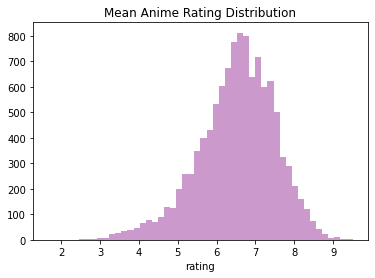

count    11194.000
mean         6.515
std          0.991
min          1.670
25%          5.940
50%          6.590
75%          7.200
max          9.500
Name: rating, dtype: float64


In [9]:
sns.distplot(anime_ratings['rating'], color='purple', kde=False)\
            .set_title('Mean Anime Rating Distribution')
plt.show()
print(anime_ratings.describe()['rating'].round(3))

Распределение средних оценок аниме, по-видимому, является нормальным со средним значением 6,5 и стандартным отклонением 1. Это согласуется с центральной предельной теоремой.

In [10]:
# genres
idx_null_genre = pd.Index(anime['genre']).isnull()
anime_allfeatures = anime.loc[~idx_null_genre]  # Drop null in 'genre'


print(pd.isnull(anime_allfeatures).sum())

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64


In [11]:
# 'episodes'
idx_ep_unknown = (anime_allfeatures['episodes'] == 'Unknown') # Drop 'Unknown' 
anime_allfeatures = anime_allfeatures.loc[~idx_ep_unknown]

# to numeric
anime_allfeatures = anime_allfeatures.astype(dtype={'episodes':'int64'})
anime_allfeatures.reset_index(inplace=True, drop=True)

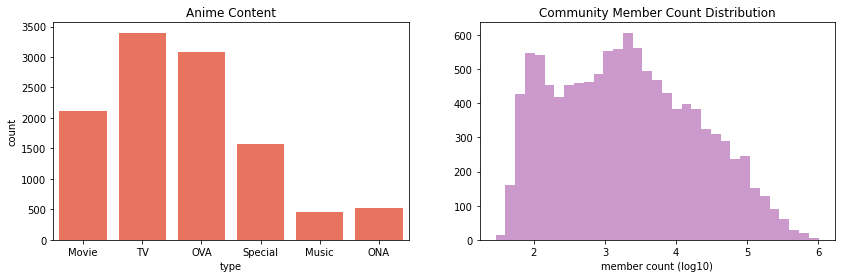

In [12]:
fig, axes = plt.subplots(1,2, figsize=(14,4))
# type counts
sns.countplot(anime_allfeatures['type'], color='tomato', ax=axes[0]).set_title('Anime Content')

# member distribution (log count)
sns.distplot(np.log10(anime_allfeatures['members'].rename('member count (log10)')),
             color='purple', kde=False, ax=axes[1])\
             .set_title('Community Member Count Distribution')
plt.show()

Для того чтобы обработать категориальные признаки `жанр` и `тип`, необходимо их превратить в числа. Это будт сделано с помощью hot-encoding.

In [13]:
# one-hot-encode 'type'
anime_allfeatures = pd.get_dummies(anime_allfeatures, columns=['type'])

# str -> list
anime_allfeatures['genre'] = anime_allfeatures['genre'].str.split(', ')

mlb = MultiLabelBinarizer()
genre_binarized = mlb.fit_transform(anime_allfeatures['genre'])
genre_binarized = pd.DataFrame(genre_binarized, 
                               columns=mlb.classes_,
                               index=anime_allfeatures.index)

anime_allfeatures = anime_allfeatures.join(genre_binarized, how='left')
anime_allfeatures.head()

,anime_id,name,genre,episodes,rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",1,9.37,200630,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",64,9.26,793665,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",51,9.25,114262,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",24,9.17,673572,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",51,9.16,151266,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


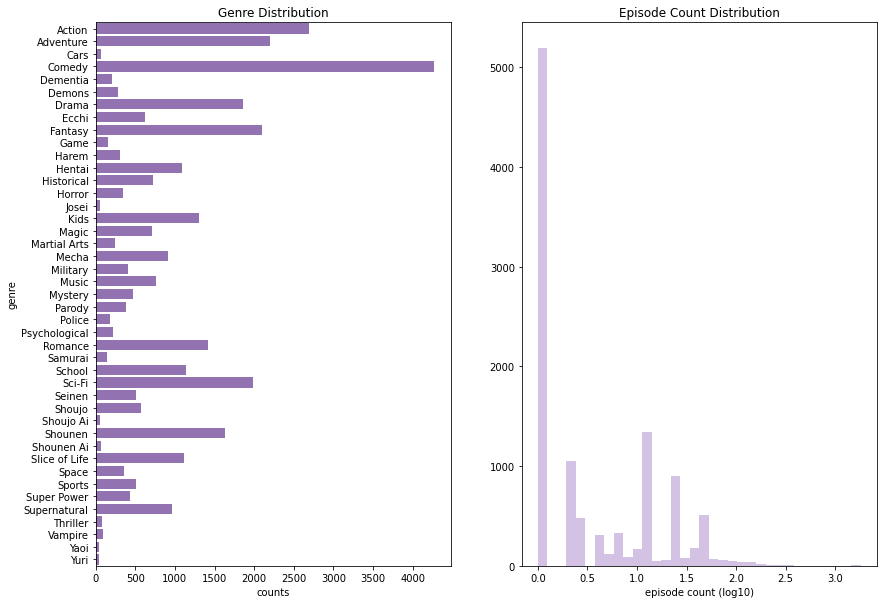

In [14]:
# Genre distribution
genre_counts = genre_binarized.sum()
genre_counts = genre_counts.to_frame(name='counts').reset_index()
genre_counts = genre_counts.rename(columns={'index':'genre'})

fig, axes = plt.subplots(1,2, figsize=(14,10))
# `type` counts
sns.barplot( y='genre', x='counts',
             data=genre_counts,
             color='tab:purple',
             ax=axes[0]
           ).set_title('Genre Distribution')


#'episodes' distribution
sns.distplot(np.log10(anime_allfeatures['episodes'].rename('episode count (log10)')),
             color='tab:purple',kde=False,
             ax=axes[1]).set_title('Episode Count Distribution')

plt.show()

Очевидно, что большая часть аниме имеет в себе *комедийные* элементы. Другие популярные жанры включают в себя *экшн*, *приключения* и *фэнтези*.

Масштабирование распределения эпизодов по log10 показывает, что большинство аниме-сериалов имеют менее 10 эпизодов, вероятно, потому, что фильмы и OVA включены в данные. Хорошая часть аниме имеет более 10 эпизодов, а некоторые из них имеют более 50 эпизодов.

Таким образом, количество эпизодов может быть разделено на категориальные признаки:
- **few**: менее 10 эпизодов
- **moderate**: от 10 до 50 эпизодов
- **many**: более 50 эпизодов

In [15]:
# One-hot-encode 'episodes' 
def categorize_episodes(episodes_col):
    if episodes_col   < 10: return 'few'
    elif episodes_col <=50: return 'moderate'
    return 'many'

anime_allfeatures['episodes_category'] = anime_allfeatures['episodes'].apply(categorize_episodes)
anime_allfeatures = pd.get_dummies(anime_allfeatures, columns=['episodes_category'], prefix='episodes')

Надо использовать аналогичную стратегию для кодирования `members`, так как ее распределение довольно редкое, оно будет разделено на 5 квантилей (приблизительно) равных размеров:
- **1-й квантиль**: 0-20% распределения
- **2-й квантиль**: 20-40% распределения
- **3-й квантиль**: 40-60% распределения
- **4-й квантиль**: 60-80% распределения
- **5-й квантиль**: 60-100% распределения


In [16]:
# 'members' quintile values
member_quantiles = [0.2, 0.4, 0.6, 0.8, 1.0]
quintile_names   = ['Q1','Q2','Q3','Q4','Q5']

member_quant_vals = anime_allfeatures['members'].quantile(member_quantiles,
                                                          interpolation='nearest').values

print('`members` Quintile values:', list(member_quant_vals))

member_q_val_map = {}
for i in range(len(member_quant_vals)):
    member_q_val_map[member_quant_vals[i]] = quintile_names[i]

# Apply member categories
def categorize_members(members_col):
    for q_val in member_quant_vals:
        if members_col <= q_val: 
            return member_q_val_map[q_val]

anime_allfeatures['members_quintile'] = anime_allfeatures['members'].apply(categorize_members)   

# One-hot-encode 'members'
anime_allfeatures = pd.get_dummies(anime_allfeatures, columns=['members_quintile'], prefix='members')
anime_allfeatures.head()

`members` Quintile values: [207, 964, 3344, 17038, 1013917]


,anime_id,name,genre,episodes,rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,episodes_few,episodes_many,episodes_moderate,members_Q1,members_Q2,members_Q3,members_Q4,members_Q5
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",1,9.37,200630,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",64,9.26,793665,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",51,9.25,114262,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",24,9.17,673572,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",51,9.16,151266,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


## Оценка
Поскольку рекомендательные системы связаны с обеспечением хорошего рейтинга для разных пользователей, нужен способ дифференцировать качество рекомендаций RecSys. Для этого нужен способ тестирования RecSys в автономном режиме с помощью ранговых метрик.

Хотя автономное тестирование имеет важное значение, реальная производительность RecSys зависит от того, насколько большую бизнес-ценность она приносит после развертывания в интернете. На практике это можно сделать, выполнив A/B тестирование.

### Выбор метрики
Чтобы оценить, насколько хороша рекомендация, нужно количественно оценить, насколько хорошо ранжируются элементы. Популярные показатели ранжирования включают **Mean Reciprocal Rank**, **Mean Average Precision (MAP@K)** и **Normalized Discounted Cumulative Gain (NDCG@K)**.

Поскольку в данном случае бинарные элементы не ранжируются (релевантные/нерелевантные), и есть ранг рекомендаций пользователя в нумерованной шкале, надо использовать **NDCG@K**, причем **K** представляет собой k-лучшиx рекомендаций, которые мы могли бы дать пользователю. **NDCG@K** предполагает, что элементы в запросе, которые появляются первыми, более важны, чем те, которые находятся ниже в списке, что подходит, так как мы хотели бы сначала рекомендовать наиболее релевантные элементы.

**Discounted Cumulative Gain (DCG@K)** - учитывает порядок элементов в списке путем домножения релевантности элемента на вес равный обратному логарифму номера позиции:

$$ DCG_K = \sum\limits_{i=1}^{K} \frac{rel_i}{\log_2{(i+1)}} $$

- $rel_i$ - the true relevance of the result at position i (e.g. assigned rating score)
- $K$ -количество элементов в рекомендуемом ранге

_________________________

Наилучший возможный ранг элементов $K$ представлен в виде **Idealized Discounted Cumulative Gain (IDCG@K)**

$$ IDCG_K = \sum\limits_{i=1}^{REL_K} \frac{rel_i}{\log_2{(i+1)}} $$

- $REL_K$ = список всех элементов корпуса, упорядоченных по убыванию релевантности до позиции $K$

_________________________


Чтобы нормализовать **DCG@K**, надо просто поделить его на **IDCG@K** и получится **Normalized Discounted Cumulative Gain (NDCG@K)**.

$$ NDCG_K = \frac{DCG_K}{IDCG_K} $$

_________________________

**NDCG** говорит нам, насколько хорошо ранжированы элементы в автономном режиме для пользователя, поэтому просто берем среднее значение всех запросов, чтобы оценить производительность механизма рекомендаций. Несколько крайних случаев, которые следует рассмотреть, заключаются в следующем:

- Когда нет подходящих документов, **IDCG** будет равен нулю. В этом случае нужно вручную установить NDCG в 0, чтобы избежать деления на ноль.
- Размер рекомендуемого списка или идеального списка может быть меньше K, поэтому нужно заполнить размер списка с минимальным DCG - 0, чтобы иметь фиксированную длину при вычислении **NDCG@K**.

In [17]:
def get_user_item_rating(user_id, item_id, user_ratings):
    '''Возвращает рейтинг, присвоенный пользователем элементу'''
    account_ratings = user_ratings.loc[user_ratings['user_id'] == user_id]
    assert account_ratings.shape[0] != 0, 'user_id не существует или ничего не смотрел'
    try:
        #print(user_id, item_id)
        return account_ratings.loc[account_ratings['anime_id']==item_id, 'rating'].values[0]
    except IndexError:
        return 0  # user has not watched anime
    

# ~~ DCG
def DCG_K(ranked_ids, user_id, K, user_ratings):
    '''Discounted Cumulative Gain для пользователя'''
    assert len(ranked_ids) <= K, 'Length of provided rankings > K !'

    pad_value = 0
    dcg = 0
    
    for idx in range(K):
        i = idx+1
        try:
            item_id = ranked_ids[idx]
            rel = get_user_item_rating(user_id, item_id, user_ratings)
        except IndexError:
            rel = pad_value 
        dcg += rel / np.log2(i+1)       
    return dcg
        

# ~~ NDCG@K
def NDCG_K(recommendations, ideal_recs, user_id, K, user_ratings):
    ''' Normalized Discounted Cumulative Gain для пользователя/запроса'''
    
    # DCG / IDCG
    dcg  = DCG_K(recommendations, user_id, K, user_ratings)
    idcg = DCG_K(ideal_recs,      user_id, K, user_ratings)
    
    if idcg == 0: return 0  #Avoid div by zero
    return dcg/idcg 


###  Подготовка данных для обучения
В отличие от автономной оценки традиционных алгоритмов машинного обучения, данные не могут быть разделены на независимые обучающие и тестовые наборы. Это связано с тем, что рекомендатели обычно должны иметь знания о пользователе во время обучения, чтобы сделать рекомендации для них во время тестирования. То же самое относится и к предметам, которые могут быть рекомендованы. В связи с этим все пользователи и предметы должны быть включены в процесс обучения и тестирования.

Для создания тестового набора будут использованы все данные. Однако обучающий набор будет состоять из части. Если бы данные рейтинга были помечены временем, можно было-бы маскировать ввод после определенной даты, а не случайным образом. Цель RecSys будет состоять в том, чтобы рекомендовать замаскированные рейтинги как хорошие рекомендации для пользователя. Набор проверки можно создать, проделав то же самое с обучающим набором.

In [18]:
def construct_rating_matrix(user_ratings_df, anime_df):
    '''
    reurns:
    - sparse rating matrix,
    - user id to matrix row index mapping
    - matrix row index to user id mapping
    - anime id to matrix col index mapping
    - matrix col index to anime id mapping
    '''
    # User & Anime ID's не находятся в идеальном хронологическом порядке
    # Map iloc to loc index so matrix indices can be mapped to ID's later
    rating_matrix_idx_user_id_map = user_ratings_df['user_id'].drop_duplicates().reset_index(drop=True).to_dict()
    user_id_rating_matrix_idx_map = {v: k for k, v in rating_matrix_idx_user_id_map.items()} #inverse map
    
    # Map iloc to loc index for anime_id
    rating_matrix_idx_anime_id_map = anime_df.reset_index()['anime_id'].to_dict()
    anime_id_rating_matrix_idx_map = {v: k for k, v in rating_matrix_idx_anime_id_map.items()} #inverse
    
    # Construct rating matrix (sparse format)
    n_users = len(rating_matrix_idx_user_id_map.keys())
    n_items = len(rating_matrix_idx_anime_id_map.keys())
    mat_shape = (n_users, n_items)   
    ratings = []
    row_idx = []
    col_idx = []
    nonzero_user_ratings = user_ratings_df.loc[user_ratings_df['rating']!=0]

    for row_tuple in nonzero_user_ratings.itertuples():
        i = user_id_rating_matrix_idx_map[row_tuple.user_id]
        j = anime_id_rating_matrix_idx_map[row_tuple.anime_id]
        row_idx.append(i)
        col_idx.append(j)
        ratings.append(row_tuple.rating)
        
    rating_matrix = csr_matrix((ratings, (row_idx, col_idx)), shape=mat_shape)
    
    return (rating_matrix,
            user_id_rating_matrix_idx_map,
            rating_matrix_idx_user_id_map,
            anime_id_rating_matrix_idx_map,
            rating_matrix_idx_anime_id_map)

In [19]:
def train_test_mask(user_ratings_df, anime_df, mask_frac=0.2, random_state=1):
    '''
    returns:
    - masked user_ratings_df
    - train  user_ratings_df
    - test  user_ratings_df
    - train rating matrix
    - test  rating matrix
    - rating matrix index mapping info
    '''
    np.random.seed(random_state)
    
    nz_user_ratings = user_ratings_df.loc[user_ratings_df.rating != 0]
    nz_ur_index = nz_user_ratings.index
    n_mask = int(mask_frac * len(nz_ur_index))
    
    # randomly mask non-zero ratings from user_ratings_df to get train user_ratings_df
    mask_idx = np.random.choice(nz_ur_index, n_mask, replace=False)
    masked_user_ratings_df = user_ratings_df.loc[mask_idx]
    
    train_user_ratings_df = user_ratings_df.copy()
    train_user_ratings_df.loc[mask_idx, 'rating'] = 0

    test_user_ratings_df = user_ratings_df
          
    # get train rating matrix, w/ mapping info
    (rating_matrix_TRAIN,
    user_id_rating_matrix_idx_map,
    rating_matrix_idx_user_id_map,
    anime_id_rating_matrix_idx_map,
    rating_matrix_idx_anime_id_map)  = construct_rating_matrix(train_user_ratings_df, anime_df)
    
    # get test rating matrix, w/ mapping info
    (rating_matrix_TEST, _, _,  _, _) = construct_rating_matrix(test_user_ratings_df, anime_df)
    
    return (masked_user_ratings_df,
            train_user_ratings_df,
            test_user_ratings_df,
            rating_matrix_TRAIN,
            rating_matrix_TEST,
            user_id_rating_matrix_idx_map,
            rating_matrix_idx_user_id_map,
            anime_id_rating_matrix_idx_map,
            rating_matrix_idx_anime_id_map)
    

def get_ideal_recommendations(masked_user_ratings, user_id, K_max):
    '''Retrieves the best possible ranking of ratings for a user which were masked in the training data'''
    user_mask = masked_user_ratings.loc[masked_user_ratings['user_id']==user_id]
    user_mask = user_mask.sort_values('rating', ascending=False)
    
    # Limit max number of recommendations to K_max
    if user_mask.shape[0] > K_max:
        user_mask = user_mask.iloc[:K_max]
    
    return list(user_mask['anime_id'].values)



def evaluate_RecSys(model, masked_user_ratings, all_user_ratings, K=10):
    ''' Вычисляет среднее значение NDCG@K по `всем пользователям с маскировкой рейтинга` в обучающих данных'''
    masked_users = masked_user_ratings['user_id'].unique()
    n_masked_users = len(masked_users)
    NDCG_sum = 0
    
    for user_id in tqdm(masked_users):
        model_recs = model.recommend(user_id, K)
        ideal_recs = get_ideal_recommendations(masked_user_ratings, user_id, K)
        NDCG_sum += NDCG_K(model_recs, ideal_recs, user_id, K, all_user_ratings)
        
    return NDCG_sum / n_masked_users
    

In [20]:
(masked_user_ratings_df,
train_user_ratings_df,
test_user_ratings_df,
rating_matrix_TRAIN,
rating_matrix_TEST,
user_id_rating_matrix_idx_map,
rating_matrix_idx_user_id_map,
anime_id_rating_matrix_idx_map,
rating_matrix_idx_anime_id_map) = train_test_mask(user_ratings, anime_ratings, mask_frac=0.2, random_state=1)


## Базовый рекомендатель
Этот рекомендатель будет рекомендовать самые популярные предметы, которые пользователь еще не видел. Надо использовать простой рекомендатель популярности для сравнения относительной производительности других более сложных рекомендательных систем.

In [21]:
# Map anime_id to descriptive info
"""
~~~~~| anime_infomap |~~~~~
        \anime_id 1-34519/
episodes: {34519: '9'}
genre   : {34519: 'Action, Fantasy, Game'},
members : {34519: 94},
name    : {34519: 'Mobile Suit Gakuen: G-Reco Koushien'},
rating  : {34519: 5.67},
type    : {34519: 'Special'}
"""    
anime_infomap = anime[['anime_id','name','genre','type','episodes','rating','members']] \
.set_index('anime_id', verify_integrity=True) \
.sort_index() \
.transpose().to_dict('index')


def get_watched(userID, user_ratings, masked_user_ratings=None):
    '''Возвращает аниме, которое пользователь уже смотрел'''
    target_user_ratings = user_ratings.loc[user_ratings['user_id'] == userID]
    watched = set(target_user_ratings['anime_id'].values)
    
    # Filter any masked ratings provided (TRAIN / TEST EVALUATION PURPOSES)
    if masked_user_ratings is not None:
        anime_id_toMask = set(masked_user_ratings.loc[user_ratings['user_id']==userID, 'anime_id'].values)
        watched = watched - anime_id_toMask  # разница в наборах
        
    if len(watched) == 0:
        print("user_id {0} does not exist or has not recorded anything as 'watched'".format(userID))
    return list(watched)


def tabulate_id_info(recommendations):
    '''
    recommendations (list) anime_id`s
    returns: рекомендаци для пользователя в dataframe'''
    n_items  = len(recommendations)
    rankings = np.arange(n_items) + 1
    
    names  = []
    genres = []
    types  = []
    episodes = []
    ratings  = []
    members  = []
    for anime_id in recommendations:
        try:
            names.append( anime_infomap['name'][anime_id])
            genres.append(anime_infomap['genre'][anime_id])
            types.append( anime_infomap['type'][anime_id])
            episodes.append(anime_infomap['episodes'][anime_id])
            ratings.append( anime_infomap['rating'][anime_id])
            members.append( anime_infomap['members'][anime_id])
        except KeyError:
            # если anime_id не существует, то никакая инфа не доступна из предоставленных данных
            names.append('n/a')
            genres.append('n/a')
            types.append('n/a')
            episodes.append('n/a')
            ratings.append('n/a')
            members.append('n/a')
        
    data = {'anime id':recommendations,
            'name': names,
            'genre': genres,
            'type': types,
            'episodes': episodes,
            'avg rating': ratings,
            'members': members}
    
    recs_df = pd.DataFrame(data=data, index=rankings)
    return recs_df

In [21]:
class popularRecommender:
    '''Рекомендатель на основе популярности аниме'''
    def __init__(self, user_ratings, ratings_mask=None):
        self.ratings = user_ratings
        self.popular_ranking = np.array([]) # initialize as empty
        self.ratings_mask = ratings_mask
        
    def train(self):
        ''' Ранжирует популярность каждого anime(id) в хронологическом порядке'''
        self.popular_ranking = self.ratings['anime_id'].value_counts().index
        
    def recommend(self, user_id, k):
        ''' Рекомендует топ K anime_id для пользователя'''
        assert len(self.popular_ranking) != 0, '-Не могу рекомендовать. Требуется тренировка'
        watched = get_watched(user_id, self.ratings, self.ratings_mask) # fetch seen items
        recommendations = []
        
        for anime_id in self.popular_ranking:
            if anime_id not in watched:
                recommendations.append(anime_id)
                
            if len(recommendations) == k:
                return recommendations
        
        # если список рекомендаций исчерпан для больших k
        print('k больше, чем число возможных рекомендаций!')
        return recommendations
        

Определив рекомендатель на основе популярности, можно получить топ-10 рекомендаций для пользователя.

In [22]:
# Топ-10 рекомендаций для пользователя 1-POPULARITY RECOMMENDER
popular_recsys = popularRecommender(user_ratings)
popular_recsys.train()
user_1_recs = popular_recsys.recommend(user_id=1, k=10)

tabulate_id_info(user_1_recs) \
.style.background_gradient(subset=['avg rating','members'],cmap=cm)

,anime id,name,genre,type,episodes,avg rating,members
1,1535,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller",TV,37,8.71,1013917
2,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super Power",TV,25,8.83,715151
3,121,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Magic, Military, Shounen",TV,51,8.33,600384
4,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665
5,2904,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super Power",TV,25,8.98,572888
6,199,Sen to Chihiro no Kamikakushi,"Adventure, Drama, Supernatural",Movie,1,8.93,466254
7,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Supernatural, Thriller",TV,26,8.07,657190
8,2167,Clannad,"Comedy, Drama, Romance, School, Slice of Life, Supernatural",TV,23,8.3,566690
9,11111,Another,"Horror, Mystery, School, Supernatural, Thriller",TV,12,7.88,534657
10,3588,Soul Eater,"Action, Adventure, Comedy, Fantasy, Shounen, Supernatural",TV,51,8.08,580184


Также можно оценить оценку производительности (mean NDCG) базовой модели.

In [45]:
# Evaluate baseline model

popular_recsys = popularRecommender(train_user_ratings_df, masked_user_ratings_df)
popular_recsys.train()
model_name = 'Popularity Recommender (baseline)'

try:
    model_results = pd.read_csv(results_path) 
except FileNotFoundError:
    model_results = pd.DataFrame(columns=['name', 'Mean NDCG (K=10)'])
    model_results.to_csv(results_path, index=False)

    
if model_name not in model_results['name'].values:
    mean_NDCG = evaluate_RecSys(popular_recsys, masked_user_ratings_df, test_user_ratings_df, K=10)   
    
    row = [model_name, mean_NDCG]
    model_results.loc[len(model_results)] = row
    model_results.to_csv(results_path, index=False)


model_results

,name,Mean NDCG (K=10)
0,Popularity Recommender (baseline),0.156098
1,Content-Based Filtering,0.068068
2,User-Based Collaborative Filtering,0.020491
3,Matrix Factorization Collaborative Filtering,0.318905


<img src='https://user-images.githubusercontent.com/54672403/83730479-d091cf80-a651-11ea-939f-82a1756f5c4f.png' width='500'>

## Фильтрация на основе контента 
[ссылка](https://developers.google.com/machine-learning/recommendation/content-based/basics)

Рекомендательные системы (RecSys) обычно подразделяются на две основные категории: **фильтрация на основе контента** и **коллаборативная фильтрация**. Фильтрация контента RecSys нацелена на предоставление рекомендаций пользователю на основе элементов, с которыми пользователь уже взаимодействовал. Если пользователь уже высоко оценил какой-либо элемент в прошлом, то фильтрация на основе содержимого позволит узнать предпочтения этого пользователя и рекомендовать элементы, соответствующие его предпочтениям и прошлым взаимодействиям.

Для этого нужно будет закодировать элементы в пространстве признаков. Пользователь также должен находиться в пространстве признаков, чтобы захватить его/ее предметы предпочтения. Затем можно было бы использовать меру [сходства](https://developers.google.com/machine-learning/recommendation/overview/candidate-generation) для определения того, насколько релевантен тот или иной элемент для пользователя в плане персонализированных рекомендаций.

Как и любая модель, эта имеет свои преимущества и недостатки:
- **Преимущества:**
    - Не требует данных других пользователей для вынесения рекомендаций.
    - Хорошо захватывает нишевые интересы пользователя, которые мало кого интересуют.
- **Недостатки:**
    - Отсутствие разнообразия - модель всегда будет рекомендовать предметы, похожие на те, с чем пользователь ранее взаимодействовал, и никогда не будет рекомендовать различные типы предметов, о которых пользователь не знает, но может понравиться.
    - Производительность модели в значительной степени зависит от хорошей разработки функций для представления элементов и пользователей в одном пространстве признаков. Знание предметной области имеет важное значение.

In [42]:
# feature representations
anime_features = anime_allfeatures.set_index('anime_id', verify_integrity=True)
anime_features = anime_features.drop(columns=['name','genre','episodes','rating','members'])
anime_features.head()\
.style.background_gradient(cmap=cm)

,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,episodes_few,episodes_many,episodes_moderate,members_Q1,members_Q2,members_Q3,members_Q4,members_Q5
anime_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32281,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
5114,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
28977,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
9253,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
9969,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


Обратите внимание, что колонка `рейтинг` была удалена, поскольку фильтрация на основе контента дает рекомендации независимо от ввода других пользователей.

Нужна рейтинговая матрица для представления предпочтений каждого пользователя. Для рейтинговой матрицы будет использоваться разреженное матричное представление, так как в системе много пользователей и элементов. Большинство пользователей видели только несколько из всей коллекции элементов, поэтому представление более эффективно для памяти.

In [43]:
# Проверка, на согласованность anime_id в user_ratings, чтобы избежать ошибок индексирования позже
ur_anime_ids = user_ratings['anime_id'].unique()
af_anime_ids = anime_features.index.values

cbf_user_ratings = user_ratings.copy()

for anime_id in ur_anime_ids:
    if anime_id not in af_anime_ids:
        cbf_user_ratings = cbf_user_ratings.loc[~(cbf_user_ratings['anime_id']==anime_id)]
        
for anime_id in af_anime_ids:
    if anime_id not in ur_anime_ids:
        anime_features = anime_features.drop(anime_id) 
        

# рейтинги пользователей для фильтрации на основе контента
cbf_user_ratings = cbf_user_ratings.reset_index(drop=True)    

In [ ]:
(cbf_masked_user_ratings_df,
cbf_train_user_ratings_df,
cbf_test_user_ratings_df,
cbf_rating_matrix_TRAIN,
cbf_rating_matrix_TEST,
cbf_user_id_rating_matrix_idx_map,
cbf_rating_matrix_idx_user_id_map,
cbf_anime_id_rating_matrix_idx_map,
cbf_rating_matrix_idx_anime_id_map) = train_test_mask(cbf_user_ratings, anime_features, mask_frac=0.2, random_state=1)

print(type(cbf_rating_matrix_TRAIN))
print(cbf_rating_matrix_TRAIN.shape)

In [30]:
# сырая матрица признаков
feature_matrix = anime_features.to_numpy(copy=True)
feature_matrix.shape

(11158, 57)

### Нормализация признаков

После создания матрицы оценок пользователей и матрицы признаков следующим шагом будет нормализация двоичных характеристик каждого аниме на квадратный корень из числа отмеченных объектов (помеченных 1). Нормализация необходима для того, чтобы избежать утяжеления предметов с большим количеством отмеченных признаков, которые намного тяжелее, чем те, у которых меньше признаков.

Точно так же мы хотели бы избежать взвешивания некоторых объектов более сильно, чем других, поэтому мы также можем нормализовать каждый объект с помощью обратной частоты документа **(IDF)**, "документы" будут пользователями.

$
IDF = \log(\frac{N}{DF})
$

- **N** = общее количество документов (пользователей) в корпусе
- **DF** = частота документов, количество документов, в которых термин (признак) появляется в корпусе

### Выработка рекомендаций

Напомним, что для того, чтобы рекомендовать элементы пользователю, надо сначала представить пользователя в том же пространстве, что и элементы. Другими словами, мы должны представлять каждого пользователя, используя те же функции, которые мы использовали для описания каждого элемента.

Предполагая, что ***R*** представляет собой рейтинговую матрицу для всех пользователей и элементов, а ***F*** - матрицу признаков для каждого элемента, матрицу представления пользователя ***U*** можно просто вывести следующим образом, где каждая строка представляет вектор профиля пользователя:
$
U = R \cdot F
$

Чтобы определить, совпадают ли предпочтения пользователя с элементом, нужно вычислить метрику сходства. В то время как существует множество метрик сходства (косинусное сходство, корреляция Пирсона и т.д.), мы выберем точечное произведение (**dot product**) в качестве метрики в этом случае, большие значения, указывают на более высокое сходство.

$
similarity = u \cdot i
$
- **u** = вектор профиля пользователя
- **i** = представление пространственных признаков элемента

In [38]:
class CBFRecommender:
    ''' рекомендатор на основе контента'''
    
    def __init__(self, rating_matrix, feature_matrix,
                 user_id_rating_matrix_idx_map,
                 rating_matrix_idx_user_id_map,
                 anime_id_rating_matrix_idx_map,
                 rating_matrix_idx_anime_id_map,
                 ratings_mask=None):
        
        # Нормализация каждого элемента по количеству признаков
        norm_vec = np.sqrt(np.sum(feature_matrix, axis=1))
        norm_feature_matrix = feature_matrix / norm_vec.reshape(-1,1)

        # Нормализация каждого признака с помощью idf этого признака
        tf  = np.sum(feature_matrix, axis=0)
        idf = np.log10(rating_matrix.shape[0] / tf)
        norm_feature_matrix = norm_feature_matrix * idf.reshape(1,-1)        
        
        self.F = csr_matrix(norm_feature_matrix) # normalized, sparse
        self.R = rating_matrix
        self.U = None   # хранит user profiles
        
        self.uid_rmi_map = user_id_rating_matrix_idx_map
        self.rmi_uid_map = rating_matrix_idx_user_id_map
        self.aid_rmi_map = anime_id_rating_matrix_idx_map
        self.rmi_aid_map = rating_matrix_idx_anime_id_map
        self.ratings_mask = ratings_mask
        
        
    def train(self):
        '''Вычисление всех векторов профилей пользователей'''
        self.U = np.dot(self.R, csr_matrix(self.F))
        
    def recommend(self, user_id, k):
        '''Рекомендует пользователю лучшие k элементов'''
        user_idx = self.uid_rmi_map[user_id]
        user_vec = self.U[user_idx]
        
        # оценка сходства с помощью  dot product
        item_scores = np.dot(user_vec, self.F.T)
        item_scores = np.ravel(item_scores.todense())
        
        # Сортировка по убыванию
        sorted_item_idx = np.argsort(item_scores)[::-1]
               
        # отфильтровать уже увиденное
        watched = get_watched(user_id, cbf_user_ratings, self.ratings_mask) # получить увиденные предметы
        recommendations = []
              
        for item_idx in sorted_item_idx:
            candidate_anime_id = self.rmi_aid_map[item_idx]
            
            if candidate_anime_id not in watched:
                recommendations.append(candidate_anime_id)
                
            if len(recommendations) == k:
                return recommendations
            
        # если список рекомендаций исчерпан для больших k
        print('k больше, чем число возможных рекомендаций!')
        return recommendations
                

Используя все приведенные данные, давайте сделаем несколько примеров рекомендаций для пользователя с нашей системой фильтрации контента RecSys.

In [ ]:
# Топ-10 рекомендаций для пользователя user_id=10
cbf = CBFRecommender(cbf_rating_matrix_TEST, feature_matrix,
                     cbf_user_id_rating_matrix_idx_map,
                     cbf_rating_matrix_idx_user_id_map,
                     cbf_anime_id_rating_matrix_idx_map,
                     cbf_rating_matrix_idx_anime_id_map)
cbf.train()
recommendations = cbf.recommend(user_id=10, k=10)
tabulate_id_info(recommendations)\
.style.background_gradient(subset=['avg rating','members'],cmap=cm)

Приведенные выше рекомендации затем можно сравнить с аниме, уже просмотренным пользователем, перечисленными ниже.

In [ ]:
# Аниме которые user_id=10 смотрел
tabulate_id_info(get_watched(userID=10, user_ratings=cbf_user_ratings))\
.style.background_gradient(subset=['avg rating','members'],cmap=cm)

Краткий осмотр показывает, что сделанные рекомендации подходят на основе прошлых взаимодействий пользователя с подобными жанрами.

Теперь давайте оценим качество автономных рекомендаций модели по сравнению с базовой моделью.

In [ ]:
# Оценка модели на основе контента
cbf_recsys = CBFRecommender(cbf_rating_matrix_TRAIN, feature_matrix,
                            cbf_user_id_rating_matrix_idx_map,
                            cbf_rating_matrix_idx_user_id_map,
                            cbf_anime_id_rating_matrix_idx_map,
                            cbf_rating_matrix_idx_anime_id_map,
                            cbf_masked_user_ratings_df)

cbf_recsys.train()
model_name = 'Content-Based Filtering'


try:# Load results if saved
    model_results = pd.read_csv(results_path) 
except FileNotFoundError:
    model_results = pd.DataFrame(columns=['name', 'Mean NDCG (K=10)'])
    model_results.to_csv(results_path, index=False)

    
if model_name not in model_results['name'].values:
    mean_NDCG = evaluate_RecSys(cbf_recsys, cbf_masked_user_ratings_df, cbf_test_user_ratings_df, K=10)   
    
    row = [model_name, mean_NDCG]
    model_results.loc[len(model_results)] = row
    model_results.to_csv(results_path, index=False)


model_results

Из полученных результатов следует, что фильтрация на основе контента не приближается к тому, чтобы превзойти базовую модель. Вероятно, это можно было бы улучшить путем тщательного отбора и разработки более описательных признаков. В следующем разделе мы попробуем другой подход.

|Тип | Определение | Пример|
|------|------|------|
|фильтрация на основе содержимого |	Использует сходство между элементами для рекомендации элементов похожих на те, что нравится пользователю.|	Если пользователь A смотрит два видео с милой кошкой, то система может рекомендовать милые животные видео для этого пользователя.|
|коллаборативная фильтрация|	Использует сходства между запросами и элементами одновременно, чтобы давать рекомендации.|	Если пользователь A похож на пользователя B, и пользователь B любит `видео-1`, то система может рекомендовать `видео 1` пользователю A (даже если пользователь A не имеет видел любые видео похожие на `видео-1`).|

## Коллаборативная фильтрация
Рекомендательные системы, использующие коллаборативную фильтрацию (CF), ориентированы на выработку рекомендаций для пользователя на основе взаимодействий других пользователей с предметами. В отличие от фильтрации на основе контента, CF способен рекомендовать элементы, которые пользователь хотел бы, но никогда бы не рассматривал. Кроме того, это семейство RecSys не зависит от разработки признаков, чтобы сделать хорошие рекомендации.

- **Преимущества:**
    - Может позволить пользователям развивать новые интересы.
    - Требуется только матрица оценки/обратной связи.
    - Знание предметной области и хорошая инженерия признаков не нужны.
- **Недостатки:**
    - Страдает от проблемы холодного старта - новый предмет не может быть рекомендован, если он не был замечен во время тренировки. В этом случае для выработки рекомендаций необходимо использовать эвристику (Heuristics).
    - Трудно объеденить признаки элемента.
    - Более высокая нагрузка на вычисления.
<br> 


CF RecSys делятся на две основные реализации:
- ***Основанная на памяти*** - эта реализация далее подразделяется на два различных подхода:
    - **Пользовательский CF**: этот подход предполагает, что пользователи с аналогичными историческими рейтингами товаров имеют схожие интересы. Оценки сходства между другими пользователями вычисляются для целевого пользователя. Затем используется подход ближайших соседей для прогнозирования рейтингов товаров, с которыми целевой пользователь еще не взаимодействовал.
    - **Item-based CF**: предполагает, что элементы, имеющие одинаковые шаблоны рейтингов по группе пользователей, хорошо рекомендовать вместе, поскольку они похожи. Таким образом, новые рекомендации составляются на основе их сходства с высокорейтинговыми предметами, с которыми пользователь взаимодействовал в прошлом. <br> <br>
- ***Model-based***: реализация сосредоточена на использовании моделей машинного обучения для рекомендации элементов пользователям. Модельные подходы включают методы матричного факторизации, SVD, PCA, нейронные сети и вероятностные методы.

### User-Based Collaborative Filtering
Для выработки рекомендаций в пользовательском CF будет использован следующий подход:
1. Вычислите сходство между пользователями
2. Найдите k-ближайших соседей пользователя (т.е. наиболее похожих пользователей на целевого пользователя)
3. Прогнозируйте рейтинги, основанные на соседстве рейтингов пользователей.

Чтобы вычислить сходство двух пользователей, мы просто сравниваем векторы рейтингов этих двух пользователей. Одним из наиболее распространенных показателей сходства, которые, как правило, обеспечивают наилучшие результаты для пользовательского CF, является **корреляция Пирсона**.

$$
sim_{\textrm{uv}} = 
\frac{\sum_{i\in{I_{\textrm{uv}}}} (r_{\textrm{ui}} - \overline{r}_\textrm{u}) (r_{\textrm{vi}} - \overline{r}_\textrm{v})}
{ 
\sqrt{ \sum_{i\in{I_{\textrm{uv}}}} (r_{\textrm{ui}} - \overline{r}_\textrm{u})^2 } 
\sqrt{ \sum_{i\in{I_{\textrm{uv}}}} (r_{\textrm{vi}} - \overline{r}_\textrm{v})^2 } 
}
$$
- $ I_{\textrm{uv}} $ =набор предметов, обычно оцениваемых пользователем $\textrm{u}$ , и пользователь $\textrm{v}$
- $ r_{\textrm{ui}} $ = рейтинг пользователя $\textrm{u}$ отданный предмету $\textrm{i}$
- $ \overline{r}_\textrm{u} $ = средние оценки от пользователя $\textrm{u}$

Затем можно рассчитать прогнозы рейтингов от пользователя для элемента следующим образом:
$$
\hat{r}_{\text{ui}} = 
\overline{r}_{\text{u}} +
\frac{\sum_{\text{v}\in{\text{N}_\text{u}}} \text{sim}_\text{uv} (r_{\textrm{vi}} - \overline{r}_\textrm{v}) }
{\sum_{\text{v}\in{\text{N}_\text{u}}} |\text{sim}_\text{uv}| }
$$

- $\hat{r}_{\text{ui}}$ = прогнозируемый рейтинг товара $\text{i}$ для пользователя $\text{u}$ 
- $\text{N}_\text{u}$ = набор пользователей по соседству с пользователем $\text{u}$


In [22]:
class userBasedCF:
    '''Рекомендатель на основе совместных пользователей '''
    def __init__(self, rating_matrix,
                 user_id_rating_matrix_idx_map,
                 rating_matrix_idx_user_id_map,
                 anime_id_rating_matrix_idx_map,
                 rating_matrix_idx_anime_id_map,
                 num_neighbours,
                 ratings_mask=None):
        
        self.R = rating_matrix
        self.uid_rmi_map = user_id_rating_matrix_idx_map
        self.rmi_uid_map = rating_matrix_idx_user_id_map
        self.aid_rmi_map = anime_id_rating_matrix_idx_map
        self.rmi_aid_map = rating_matrix_idx_anime_id_map
        self.ratings_mask = ratings_mask
        self.num_neighbours = num_neighbours
        
    
    def user_pearson_correlation(self, u, v):
        '''Возвращает корреляцию Пирсона между user rating vectors (u, v)'''
        # получите набор наиболее часто оцениваемых индексов товаров
        u_nonzero_flag = (u != 0)
        v_nonzero_flag = (v != 0)
        common_idx_flag = u_nonzero_flag & v_nonzero_flag

        # случай, когда нет общих оценок между пользователями
        if np.sum(common_idx_flag) == 0: return 0        


        u_common_nz = u[common_idx_flag]
        v_common_nz = v[common_idx_flag]

        # mean non-zero ratings for users
        u_mean = np.mean(u[u_nonzero_flag])
        v_mean = np.mean(v[v_nonzero_flag])

        num   = np.sum( (u_common_nz - u_mean) * (v_common_nz - v_mean) )
        denom = np.sqrt(np.sum((u_common_nz - u_mean)**2)) * np.sqrt(np.sum((v_common_nz - v_mean)**2))
        
        if denom == 0: return 0
        return num / denom
    
    
    def k_user_neighbours(self, user_id, k):
        ''' retrun: the k nearest neighbour user_ids to a user'''
        user_index = self.uid_rmi_map[user_id]
        u_ratings = np.ravel(self.R[user_index].todense())
        
        user_correlations = [self.user_pearson_correlation(u_ratings, np.ravel(self.R[u_idx].todense()))
                             for u_idx in range(self.R.shape[0])]
            
        # return user_ids with top k similarities
        user_correlations = np.array(user_correlations)
        user_correlations[user_index] = -99 # удалить целевого пользователя, принудительно установить низкое значение

        # filter top k, convert to user_ids
        neighbour_user_idx = np.argpartition(-user_correlations, np.arange(k))[:k] # sort top k, descending          
        neighbour_ids = [self.rmi_uid_map[u_idx] for u_idx in neighbour_user_idx]
        return neighbour_ids
    
    
    def predict_rating(self, user_id, item_id, neighbour_user_ids):
        '''Returns a prediction of the rating of an item for a user'''
        user_index = self.uid_rmi_map[user_id]
        u_ratings  = np.ravel(self.R[user_index].todense())
        nz_ratings = u_ratings[u_ratings!=0]
        
        # Check for all ratings == zero
        if len(nz_ratings) == 0: return 0
        
        u_mean = np.mean(nz_ratings)
        item_idx = self.aid_rmi_map[item_id]        
        num = 0
        denom = 0
        
        for neighbour_id in neighbour_user_ids:
            neighbour_idx = self.uid_rmi_map[neighbour_id]
            neighbour_ratings = np.ravel(self.R[neighbour_idx].todense())
            neighbour_nz_ratings = neighbour_ratings[neighbour_ratings!=0]
            
            if len(neighbour_nz_ratings) == 0:
                neighbour_mean_rating = 0
            else:
                neighbour_mean_rating = np.mean(neighbour_nz_ratings)
            
            similarity = self.user_pearson_correlation(u_ratings, neighbour_ratings)
            neighbour_item_rating = neighbour_ratings[item_idx]
                     
            num += similarity * (neighbour_item_rating - neighbour_mean_rating)
            denom += np.abs(similarity)
            
        if denom==0: return u_mean
        return u_mean + num/denom
        
    
    def recommend(self, user_id, k):
        '''Recommends top k items to a user'''
        watched = get_watched(user_id, user_ratings, self.ratings_mask)
        recommendations = []
        rec_ratings = []
        neighbour_user_ids = self.k_user_neighbours(user_id, self.num_neighbours)
        
        for item_id in self.aid_rmi_map.keys():
            if item_id not in watched:
                item_rating = self.predict_rating(user_id, item_id, neighbour_user_ids)
                rec_ratings.append(item_rating)
                recommendations.append(item_id)
        
        recommendations = np.array(recommendations)
        rec_ratings = np.array(rec_ratings)
        rec_indices = np.argpartition(-rec_ratings, np.arange(k))[:k] # sort top-k idx
        recommendations = recommendations[rec_indices] # recommend top-k based on rating
        return list(recommendations)

Составляя некоторые примеры рекомендаций с помощью user-based collaborative filtering RecSys , получаем следующее:

In [23]:
# Топ-10 рекомендаций для пользователя user_id=10
# 20 билижайших соседей
user_CF = userBasedCF(rating_matrix_TEST,
                      user_id_rating_matrix_idx_map,
                      rating_matrix_idx_user_id_map,
                      anime_id_rating_matrix_idx_map,
                      rating_matrix_idx_anime_id_map,
                      num_neighbours=20)

recommendations = user_CF.recommend(user_id=10, k=10)
tabulate_id_info(recommendations)\
.style.background_gradient(subset=['avg rating','members'],cmap=cm)

,anime id,name,genre,type,episodes,avg rating,members
1,19815,No Game No Life,"Adventure, Comedy, Ecchi, Fantasy, Game, Supernatural",TV,12,8.47,602291
2,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
3,22199,Akame ga Kill!,"Action, Adventure, Fantasy",TV,24,7.84,492133
4,5680,K-On!,"Comedy, Music, School, Slice of Life",TV,13,7.87,386048
5,2001,Tengen Toppa Gurren Lagann,"Action, Adventure, Comedy, Mecha, Sci-Fi",TV,27,8.78,562962
6,9919,Ao no Exorcist,"Action, Demons, Fantasy, Shounen, Supernatural",TV,25,7.92,583823
7,18679,Kill la Kill,"Action, Comedy, School, Super Power",TV,24,8.23,508118
8,7791,K-On!!,"Comedy, Music, School, Slice of Life",TV,26,8.14,246276
9,2167,Clannad,"Comedy, Drama, Romance, School, Slice of Life, Supernatural",TV,23,8.3,566690
10,30276,One Punch Man,"Action, Comedy, Parody, Sci-Fi, Seinen, Super Power, Supernatural",TV,12,8.82,552458


Поскольку эта реализация на основе памяти требует вычисления ближайших соседей между всеми пользователями, она не очень масштабируема для реальных приложений, где в базе данных существует большое количество пользователей. Поскольку **масштабируемость является главным недостатком**, мы проведем оценку этой user-based collaborative filtering с гораздо меньшим набором тестов (меньше замаскированных оценок).

In [24]:
# Evaluation with much smaller testing split
(masked_user_ratings_df2,
train_user_ratings_df2,
test_user_ratings_df2,
rating_matrix_TRAIN2,
rating_matrix_TEST2,
user_id_rating_matrix_idx_map2,
rating_matrix_idx_user_id_map2,
anime_id_rating_matrix_idx_map2,
rating_matrix_idx_anime_id_map2) = train_test_mask(user_ratings, anime_ratings, mask_frac=0.0001, random_state=1)

In [27]:
# user-based collaborative filtering model
user_CF = userBasedCF(rating_matrix_TRAIN2,
                      user_id_rating_matrix_idx_map2,
                      rating_matrix_idx_user_id_map2,
                      anime_id_rating_matrix_idx_map2,
                      rating_matrix_idx_anime_id_map2,
                      num_neighbours=10,
                      ratings_mask=masked_user_ratings_df2)

model_name = 'User-Based Collaborative Filtering'


try: # Load results if saved
    model_results = pd.read_csv(results_path) 
except FileNotFoundError:
    model_results = pd.DataFrame(columns=['name', 'Mean NDCG (K=10)'])
    model_results.to_csv(results_path, index=False)

    
if model_name not in model_results['name'].values:
    mean_NDCG = evaluate_RecSys(user_CF, masked_user_ratings_df2, test_user_ratings_df2, K=10)    
    row = [model_name, mean_NDCG]
    model_results.loc[len(model_results)] = row
    model_results.to_csv(results_path, index=False)

model_results

,name,Mean NDCG (K=10)
0,Popularity Recommender (baseline),0.156098
1,Content-Based Filtering,0.068068
2,User-Based Collaborative Filtering,0.020491
3,Matrix Factorization Collaborative Filtering,0.318905


Хотя данные для тестовой выборки были значительно меньше, user-based CF  работает даже хуже, чем фильтрация на основе контента в среднем. Это обнажает еще один недостаток методов CF на основе памяти: высокая разреженность данных затрудняет поиск подходящих соседей для выработки новых рекомендаций.

In [30]:
total_elements = rating_matrix_TRAIN2.shape[0] * rating_matrix_TRAIN2.shape[1]
sparsity = (total_elements - rating_matrix_TRAIN2.nnz) / total_elements
print('rating matrix sparsity: {:.4}'.format(sparsity))

rating matrix sparsity: 0.9923


###  Коллаборативная фильтрация на основе элементов
Подобно user-based CF , коллаборативная фильтрация на основе элементов предполагает построение окрестностей на основе сходства. Как следует из его названия, в этой реализации сравнивается сходство элементов. Каждый элемент просто представлен в виде вектора присвоенных ему оценок пользователей.

Для выработки рекомендаций использован следующий подход:
1. Вычислите сходство между **элементами**
2. Найдите k-ближайших соседей элемента (т.е. наиболее похожих элементов на целевой элемент)
3. Прогнозировать рейтинги, основанные на соседстве рейтингов товаров.

Сходство элементов вычисляется путем сравнения рейтинговых векторов двух элементов. Популярной метрикой сходства для CF на основе элементов является **косинусное сходство**, поскольку его можно быстро вычислить. Существует вариант под названием **скорректированное косинусное сходство**, который объясняет смещение оценок пользователей (некоторые пользователи обычно оценивают предметы выше, чем другие). Эта метрика вычисляется следующим образом:

$$
\text{sim}_\text{ij} = \frac{
\sum_{\text{u}\in{\text{U}_\text{ij}}} (r_\text{ui} - \overline{r}_\text{u}) (r_\text{uj} - \overline{r}_\text{u})
}
{
\sqrt{\sum_{\text{u}\in{\text{U}_\text{i}}} (r_\text{ui} - \overline{r}_\text{u})^2}
\sqrt{\sum_{\text{u}\in{\text{U}_\text{j}}} (r_\text{uj} - \overline{r}_\text{u})^2}
}
$$

- $ \text{U}_\text{i} $ = набор пользователей, оценивших товар $\text{i} $
- $ \text{U}_\text{j} $ = набор пользователей, оценивших товар $\text{j} $
- $ \text{U}_\text{ij} $ = набор пользователей, оценивших оба элемента $\text{i} $ и $\text{j} $
- $ \overline{r}_\textrm{u} $ = средние оценки от пользователя $\textrm{u}$
- $ r_\text{ui} $ = рейтинг пользователя $\textrm{u}$ для товара $\text{i}$

После этого можно будет сделать рейтинговые прогнозы, соответствующие элементу и пользователю:
$$
\hat{r}_{\text{ui}} = 
\overline{r}_{\text{i}} +
\frac{\sum_{\text{j}\in{\text{N}_\text{i}}} \text{sim}_\text{ij} (r_{\textrm{uj}} - \overline{r}_\textrm{j}) }
{\sum_{\text{j}\in{\text{N}_\text{i}}} |\text{sim}_\text{ij}| }
$$
- $\hat{r}_{\text{ui}}$ = прогнозируемый рейтинг товара $\text{i}$ для пользователя $\text{u}$ 
- $\text{N}_\text{i}$ = набор предметов по соседству с предметом$\text{i}$
- $ \overline{r}_\textrm{i} $ = средняя оценка, данная товару $\textrm{i}$

CF на основе элементов предпочтительнее user-based, когда в системе гораздо больше пользователей, чем элементов, так как он имеет более низкую вычислительную нагрузку. Несмотря на это, основанный на памяти алгоритм CF, все еще страдает от проблем масштабируемости из-за вычисления ближайших соседей.

In [32]:
class itemBasedCF:
    '''Item-based collaborative filtering Recommender'''
    def __init__(self, rating_matrix,
                 user_id_rating_matrix_idx_map,
                 rating_matrix_idx_user_id_map,
                 anime_id_rating_matrix_idx_map,
                 rating_matrix_idx_anime_id_map,
                 num_neighbours,
                 ratings_mask=None):
        
        self.R = rating_matrix
        self.uid_rmi_map = user_id_rating_matrix_idx_map
        self.rmi_uid_map = rating_matrix_idx_user_id_map
        self.aid_rmi_map = anime_id_rating_matrix_idx_map
        self.rmi_aid_map = rating_matrix_idx_anime_id_map
        self.ratings_mask = ratings_mask
        self.num_neighbours = num_neighbours
        self.R_userMeans = rating_matrix.mean(axis=1)
        

    def get_item_similarities(self, item_id):
        '''Вычисляет скорректированное косинусное сходство между item_id и всеми другими элементами'''
        item_idx = self.aid_rmi_map[item_id]
        cos_distances = metrics.pairwise_distances(self.R.T[item_idx] - self.R_userMeans.T,
                                                   self.R.T,
                                                   metric='cosine',
                                                   n_jobs=-1)
        adj_cos_sim = 1 - cos_distances
        return np.ravel(adj_cos_sim)

    
    
    def k_item_neighbours(self, item_id, k):
        '''returns:  knn item_ids to an item'''
        item_index = self.aid_rmi_map[item_id]
        item_correlations = self.get_item_similarities(item_id)
        item_correlations[item_index] = -1 # удалить целевой элемент, принудительно установить низкое значение сходства
        
        # filter top k, convert to item_ids
        neighbour_item_idx = np.argpartition(-item_correlations, np.arange(k))[:k] # сортировка top k, по убыванию         
        neighbour_ids = [self.rmi_aid_map[i_idx] for i_idx in neighbour_item_idx]     
        return neighbour_ids
    
    

    def predict_rating(self, user_id, item_id, neighbour_item_ids):
        '''Возвращает прогнозирование рейтинга элемента для пользователя'''
        item_index = self.aid_rmi_map[item_id]
        i_ratings = np.ravel(self.R[:, item_index].todense())
        nz_ratings = i_ratings[i_ratings!=0]
        
        # Check all ratings == zero
        if len(nz_ratings) == 0: return 0
        
        i_mean = np.mean(nz_ratings)
        user_idx = self.uid_rmi_map[user_id]
        num = 0
        denom = 0
        
        for neighbour_id in neighbour_item_ids:
            neighbour_idx = self.aid_rmi_map[neighbour_id]
            neighbour_ratings = np.ravel(self.R[:, neighbour_idx].todense())
            neighbour_nz_ratings = neighbour_ratings[neighbour_ratings!=0]

            similarity = self.get_item_similarities(item_id)[neighbour_idx]
            neighbour_user_rating = neighbour_ratings[user_idx]
            
            if len(neighbour_nz_ratings) == 0:
                neighbour_mean_rating = 0
            else:
                neighbour_mean_rating = np.mean(neighbour_nz_ratings)
            
            num += similarity * (neighbour_user_rating - neighbour_mean_rating)
            denom += np.abs(similarity)
            
        if denom==0: return i_mean
        return i_mean + num/denom   
    
    
    
    def recommend(self, user_id, k):
        ''' Рекомендует top-k товаров пользователю'''
        watched = get_watched(user_id, user_ratings, self.ratings_mask)
        recommendations = []
        rec_ratings = []
        
        for item_id in tqdm(self.aid_rmi_map.keys()):
            if item_id not in watched:
                neighbour_item_ids = self.k_item_neighbours(item_id, self.num_neighbours)               
                item_rating = self.predict_rating(user_id, item_id, neighbour_item_ids)
                rec_ratings.append(item_rating)
                recommendations.append(item_id)
        
        recommendations = np.array(recommendations)
        rec_ratings = np.array(rec_ratings)
        rec_indices = np.argpartition(-rec_ratings, np.arange(k))[:k] # sort top-k idx
        recommendations = recommendations[rec_indices] # Рекомендовать top-k на основе рейтинга
        return list(recommendations)

Генерируя некоторые примеры рекомендаций с использованием item-based CF, получаем следующее:

In [34]:
# Топ-10 рекомендаций для пользователя user_id=10
# 20 билижайших соседей
item_CF = itemBasedCF(rating_matrix_TEST,
                      user_id_rating_matrix_idx_map,
                      rating_matrix_idx_user_id_map,
                      anime_id_rating_matrix_idx_map,
                      rating_matrix_idx_anime_id_map,
                      num_neighbours=20)


try:
    ibcf_recommendations = pd.read_csv('ibcfRecs_u10.csv', index_col=0)
except FileNotFoundError:
    recommendations = item_CF.recommend(user_id=10, k=10)
    ibcf_recommendations = tabulate_id_info(recommendations)
    ibcf_recommendations.to_csv('ibcfRecs_u10.csv')

ibcf_recommendations\
.style.background_gradient(subset=['avg rating','members'],cmap=cm)

,anime id,name,genre,type,episodes,avg rating,members
1,9900,Hamster Club,Kids,TV,140,6.65,318
2,5477,Gozonji! Gekkou Kamen-kun,"Comedy, Parody, Sci-Fi",TV,25,7,178
3,30743,Kanagatari. Kanabakari.: Kanadian Families,Slice of Life,OVA,1,6.36,209
4,15961,Shakotan★Boogie,"Action, Cars, Comedy, School, Seinen",OVA,4,7.6,169
5,12039,What's Michael? (TV),Comedy,TV,45,7.13,208
6,10113,Yokohama Meibutsu: Otoko Katayama-gumi!,"Action, School, Shounen",OVA,2,6.53,150
7,8478,Doubutsu Kankyou Kaigi,Kids,TV,20,5.68,151
8,29837,"Yakushiji Ryouko no Kaiki Jikenbo: Hamachou, Voice & Fiction","Mystery, Police, Supernatural",Special,1,5.97,190
9,11221,Machikado no Märchen,Romance,OVA,1,6.59,333
10,9944,Hime Gal♥Paradise,Shoujo,OVA,9,6.21,563


Kак и  user-based CF, качество рекомендаций item-based CF страдает от проблем разреженности. Это видно из жанровых рекомендаций, сгенерированных для пользователя (Пользователь №10), который в основном видел жанры экшена, приключений и фэнтези.

Как уже упоминалось ранее, поскольку item-based CF - это реализация на основе памяти, которая имеет высокую вычислительную нагрузку из-за вычислений ближайших соседей, мы не будем оценивать RecSys с помощью тестового набора.

### Matrix Factorization

![MF image](https://miro.medium.com/max/988/1*tiF4e4Y-wVH732_6TbJVmQ.png)

Матричная факторизация - это реализация на основе модели, которая направлена на аппроксимацию рейтинговой матрицы путем построения латентного пространства более низкой размерности.

Факторизация рейтинговой матрицы $R$ аппроксимируется произведением пользовательской матрицы $U$ и товарной матрицы $V$.
$$
R \approx U \times V
$$

где,  $U \in \mathbb{R}^{m\times d}$ and $V \in \mathbb{R}^{n\times d}$. Выбранное измерение латентного представления характеризуется признаками $d$.

Распространенным подходом к факторизации матрицы является vanilla SVD, однако это приводит к низкой производительности обобщения и не очень хорошо подходит для разреженных матриц. Как и другие алгоритмы машинного обучения, нам необходимо включить термин регуляризации, чтобы избежать переобучения модели. Таким образом, целевая функция минимизации состоит в следующем:

$$
\min_{x,y} \sum_{u,i}(r_{ui} - x_uy^T_i)^2 + \lambda(\sum_u \Vert x_u \Vert^2 + \sum_i \Vert y_i \Vert^2)
$$

- $r_{ui}$ = фактический рейтинг, присвоенный пользователем $u$ элементу $i$
- $x_u$ = user $u$'s vector embedding in matrix $U$
- $y_i$ = item $i$'s vector embedding in matrix $V$
- $\lambda$ = коэффициент регуляризации


Задача может быть сведена к минимуму с помощью стохастического градиентного спуска (SGD), однако мы предпочтем использовать **Weighted Alternating Least Squares (WALS)**, которые специализируются для этой конкретной цели. WALS в этом случае выгоден SGD, так как он может быть распараллелен и сходится быстрее. WALS выполеятся так:

1. Randomly initialize user latent vectors $U$, and item latent vectors $V$
2. Fix $U$ and solve $V$
3. Fix $V$ and solve $U$
4. Повторяйте шаги 2 и 3 до тех пор, пока не произойдет конвергенция

Стратегия чередующейся оптимизации позволяет нам непосредственно решать для прямого решения на каждом последовательном шаге. Это позволяет оптимизировать ряд подзадач, а не одну сложную задачу при попытке решить ее для $U$ и $V$ одновременно.

In [35]:
class MF_recommender:
    '''Матричная факторизационная модель, реализованная с чередованием наименьших квадратов'''
    def __init__(self, rating_matrix,
                 user_id_rating_matrix_idx_map,
                 rating_matrix_idx_user_id_map,
                 anime_id_rating_matrix_idx_map,
                 rating_matrix_idx_anime_id_map,
                 factors,
                 regularization,
                 iterations,
                 ratings_mask=None):
        
        self.R= rating_matrix
        self.n_latentFactors = factors
        self.lambdaReg = regularization
        self.n_iter = iterations
        self.user_factors = None
        self.item_factors = None
        
        self.uid_rmi_map = user_id_rating_matrix_idx_map
        self.rmi_uid_map = rating_matrix_idx_user_id_map
        self.aid_rmi_map = anime_id_rating_matrix_idx_map
        self.rmi_aid_map = rating_matrix_idx_anime_id_map
        self.ratings_mask = ratings_mask
        
        
    def train(self):
        MF_model = implicit.als.AlternatingLeastSquares(factors = self.n_latentFactors,
                                                        regularization = self.lambdaReg,
                                                         iterations = self.n_iter)
        MF_model.fit(self.R.T)                    # fits on transpose
        self.user_factors = MF_model.user_factors # User matrix 'U'
        self.item_factors = MF_model.item_factors # Item matrix 'V'
        print("Training Complete\n")
        
        
    def predict_rating(self, user_id, item_id):
        user_idx = self.uid_rmi_map[user_id]
        item_idx = self.aim_rmi_map[user_id]
        u = self.user_factors[user_idx]
        v = self.item_factors[item_idx]
        return u.dot(v.T)
    
    
    def recommend(self, user_id, k):
        '''Recommends top k items to a user'''
        watched = get_watched(user_id, user_ratings, self.ratings_mask)
        watched_idx = np.array([self.aid_rmi_map[item_id] for item_id in watched])
        
        u_idx = self.uid_rmi_map[user_id]
        u = self.user_factors[u_idx]
        pred_user_ratings = np.ravel(u.dot(self.item_factors.T))
        
        if len(watched_idx) > 0:
            pred_user_ratings[watched_idx] = -1  # Mask out items already seen with -1 rating
        
        rec_indices = np.argpartition(-pred_user_ratings, np.arange(k))[:k] # sort top-k idx              
        recommendations = [self.rmi_aid_map[item_idx] for item_idx in rec_indices]
        return recommendations

Используя определенную модель матричного факторизации, сгенерируем некоторые примеры рекомендаций:

In [36]:
# Топ-10 рекомендаций для пользователя user_id=10
n_latentFactors = 20
lambda_reg = 0.1
n_iterations = 30

MF_CF_model = MF_recommender(rating_matrix_TEST,
                             user_id_rating_matrix_idx_map,
                             rating_matrix_idx_user_id_map,
                             anime_id_rating_matrix_idx_map,
                             rating_matrix_idx_anime_id_map,
                             n_latentFactors,
                             lambda_reg,
                             n_iterations)
MF_CF_model.train()
recommendations = MF_CF_model.recommend(user_id=10, k=10)
tabulate_id_info(recommendations)\
.style.background_gradient(subset=['avg rating','members'],cmap=cm)


Training Complete



,anime id,name,genre,type,episodes,avg rating,members
1,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super Power",TV,25,8.83,715151
2,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
3,2904,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super Power",TV,25,8.98,572888
4,9919,Ao no Exorcist,"Action, Demons, Fantasy, Shounen, Supernatural",TV,25,7.92,583823
5,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Supernatural, Thriller",TV,26,8.07,657190
6,121,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Magic, Military, Shounen",TV,51,8.33,600384
7,22319,Tokyo Ghoul,"Action, Drama, Horror, Mystery, Psychological, Seinen, Supernatural",TV,12,8.07,618056
8,6702,Fairy Tail,"Action, Adventure, Comedy, Fantasy, Magic, Shounen",TV,175,8.22,584590
9,19815,No Game No Life,"Adventure, Comedy, Ecchi, Fantasy, Game, Supernatural",TV,12,8.47,602291
10,3588,Soul Eater,"Action, Adventure, Comedy, Fantasy, Shounen, Supernatural",TV,51,8.08,580184


Используя модель матричного факторизации, качество рекомендаций, по-видимому, улучшилось для пользователя №10, причем было рекомендовано гораздо больше жанров экшена и приключений.

Теперь давайте посмотрим, как наша модель матричного факторизации работает на нашем тестовом разбиении после обучения на обучающих данных.

In [37]:
MF_CF_model = MF_recommender(rating_matrix_TRAIN,
                             user_id_rating_matrix_idx_map,
                             rating_matrix_idx_user_id_map,
                             anime_id_rating_matrix_idx_map,
                             rating_matrix_idx_anime_id_map,
                             n_latentFactors,
                             lambda_reg,
                             n_iterations,
                             masked_user_ratings_df)
MF_CF_model.train()
model_name = 'Matrix Factorization Collaborative Filtering'

try: # Load results if saved
    model_results = pd.read_csv(results_path) 
except FileNotFoundError:
    model_results = pd.DataFrame(columns=['name', 'Mean NDCG (K=10)'])
    model_results.to_csv(results_path, index=False)

    
if model_name not in model_results['name'].values:
    mean_NDCG = evaluate_RecSys(MF_CF_model, masked_user_ratings_df, test_user_ratings_df, K=10)       
    row = [model_name, mean_NDCG]
    model_results.loc[len(model_results)] = row
    model_results.to_csv(results_path, index=False)

    
model_results


Training Complete



,name,Mean NDCG (K=10)
0,Popularity Recommender (baseline),0.156098
1,Content-Based Filtering,0.068068
2,User-Based Collaborative Filtering,0.020491
3,Matrix Factorization Collaborative Filtering,0.318905


После оценки матрично-факторизационной модели CF обнаруживаем, что она значительно превосходит все остальные RecSys, что делает ее лучшим рекомендателем в этом случае. Это в основном связано с тем, что матричная факторизация менее подвержена ухудшению качества рекомендаций на основе разреженных рейтинговых данных. Еще одно преимущество матричного факторизации заключается в том, что она масштабируется по сравнению с другими методами CF, которые требуют решения проблемы ближайших соседей.


## Заключение
Единственной моделью, способной превзойти базовый показатель популярности, была модель матричного факторизации CF. Эффективность деятельности user-based CF и item-based CF сильно страдает от разряженных данных, и не масштабируется для больших наборов данных. Фильтрация на основе контента также выполняется плохо по сравнению с базовым уровнем при включении всех предоставляемых функций. Его можно было бы еще больше улучшить с помощью правильного выбора функций и дополнительного проектирования параметров. Недостатком матричного факторизации является то, что она затрудняет включение признаков. Это может быть облегчено с помощью гибридных рекомендательных систем, которые объединяют рекомендации различных RecSys.

1. https://developers.google.com/machine-learning/recommendation
2. https://www.analyticsvidhya.com/blog/2015/08/beginners-guide-learn-content-based-recommender-systems/
3. http://fastml.com/evaluating-recommender-systems/
4. https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832
5. http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html#In-which-I-spare-you-an-abundance-of-%22map%22-related-puns-while-explaining-what-Mean-Average-Precision-is.
6. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8506344
7. http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf
8. https://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/recsys/1_ALSWR.ipynb
9. http://yifanhu.net/PUB/cf.pdf